In [354]:
import torch
import dill
import warnings
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

from src.pde_PINN_hardBC_elliptic import PDE_PINN_HARDBC_ELLIPTIC
from src.pde_PINN_wave import PDE_PINN_WAVE


In [361]:
def Savepickle(obj, doc_path):
    with open(doc_path, 'wb') as file:
        dill.dump(obj, file)     

def Readpickle(doc_path):
    with open(doc_path, 'rb') as file:
        return dill.load(file)
    
def SaveModel(model, path): 
    if model.model_type == 'PDE_PINN_HARDBC_ELLIPTIC':
        data = {'model_type': model.model_type,
                'f': model.f, 
                'rec_bound' : model.rec_bound,
                'BC' : model.BC , 
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
        
    elif model.model_type == 'PDE_PINN_WAVE':
        data = {'model_type': model.model_type,
                'paras': (model.c , model.a , model.b , model.T),
                'BC': (model.g, model.phi),
                'lambdas': model.lambdas,
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}  
    Savepickle(data, path)
    
def LoadModel(path):
    data = Readpickle(path)
    
    try:
        rff_B = data['rff_B']
    except:
        rff_B = None
    
    if data['model_type'] == 'PDE_PINN_HARDBC_ELLIPTIC':
        model = PDE_PINN_HARDBC_ELLIPTIC(f=data['f'], rec_bound=data['rec_bound'], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
        
    elif data['model_type'] == 'PDE_PINN_WAVE':
        model =  PDE_PINN_WAVE(paras=data['paras'], BC=data['BC'], lambdas=data['lambdas'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'],
                                set_rff=data['rff_para'][0], rff_num=data['rff_para'][1], 
                                u=data['rff_para'][2], std=data['rff_para'][3], rff_B=rff_B)
          
    model.load_state_dict(data['para_dict'])
    model.validate_loss = data['validate_loss']
    model.train_loss = data['train_loss']
    model.L2_loss = data['L2_loss']
    return model

def moving_average(x, half_window_size):
    res = []
    x = np.array(x)
    for i in range(len(x)):
        if i == 0:
            res.append(x[i]) 
        elif i < half_window_size:
            res.append(x[0:2*i+1].mean())
        elif i <= len(x)-1-half_window_size:
            res.append(x[i-half_window_size:i+half_window_size+1].mean())
        else:
            res.append(x[2*i+1-len(x):].mean())
    return res

# Elliptic, Rectangle Region, Dirichlet

In [424]:
## Setting parameters
# Force functions and True solutions
f = lambda xy : (-13 * torch.pi**2 * torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)
u_true = lambda xy : (torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)

# BCs
rec_bound = (0,1,0,1)
ua = lambda x : 0
ub = lambda x : 0
uc = lambda x : 0
ud = lambda x : 0
BCs = [ua, ub, uc, ud]

In [ ]:
# Construct model
model = PDE_PINN_HARDBC_ELLIPTIC( f, rec_bound, BCs, 
                                  n_hidden=50, n_layers=3,
                                  set_rff=False, rff_num=25, u=0, std=1, rff_B=None )

model.Train( train_num=2000, train_batch_size=32, learning_rate=0.01,  
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=100, compute_L2_loss=True, true_sol=u_true, display=True )
# SaveModel(model, './data/PDE_Elliptic_Solver.pkl')

# Hyperbolic, 2 Space Wave

In [ ]:
# Construct model
model = PDE_PINN_WAVE( paras=(1,1,1,5), BC=(lambda x:0, lambda x:1), lambdas=(1,20,20,20,20,20,20),
                       n_hidden=128, n_layers=5 )

true_sol = lambda xyt: model.true_sol(xyt,k=2)
model.Train( train_num=2500, train_batch_size=32, learning_rate=0.0001,  
              lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
              abs_tolerance=1e-4, max_epoch=16000, display=True)
# SaveModel(model, './data/PDE_Wave_Solver.pkl')

# Visualization

## Loss

In [ ]:
# Load Model
Elliptic_Solver = LoadModel('./data/PDE_Elliptic_Solver.pkl')
Wave_Solver = LoadModel('./data/PDE_Wave_Solver.pkl')
Elliptic_true = lambda xy : (torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)

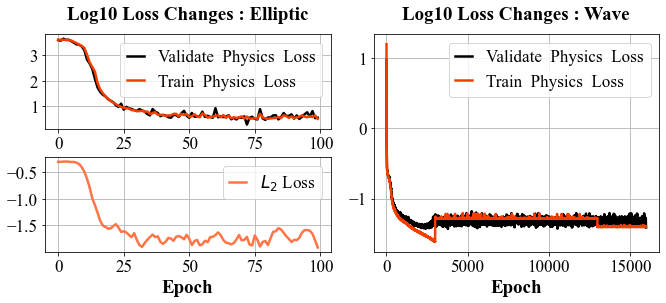

In [476]:
## Plot loss changes
fig, ax = plt.subplots( figsize=( 11 , 4 ) )
title_fontsize = 19
tick_size = 17
leg_size  = 17

ax  = [plt.subplot(221), plt.subplot(223), plt.subplot(122)]

ax[0].plot(np.log10(Elliptic_Solver.validate_loss), label='Validate  Physics  Loss', linewidth=2.5, color='#000000')    
ax[0].plot(np.log10(Elliptic_Solver.train_loss), label='Train  Physics  Loss', linewidth=2.5, color='#f53d00')    
ax[1].plot(moving_average(np.log10(Elliptic_Solver.L2_loss),2), label='$L_2$ Loss', linewidth=2.5, color='#ff7547')   

ax[2].plot(moving_average(np.log10(Wave_Solver.validate_loss), 5)[:-1],
           label='Validate  Physics  Loss', linewidth=2.5, color='#000000')    
ax[2].plot(moving_average(np.log10(Wave_Solver.train_loss), 2)[:-1],
           label='Train  Physics  Loss', linewidth=2.5, color='#f53d00')    

for i in range(3):
    ax[i].grid()
    ax[i].legend(loc='upper right', fontsize=leg_size, handlelength=1.0)
    
    if i == 0 :
        ax[i].set_title('Log10 Loss Changes : Elliptic', fontsize=title_fontsize, fontweight='bold', pad=15)
    if i == 1 :
        ax[i].set_xlabel('Epoch', fontsize=title_fontsize, fontweight='bold') 
    elif i == 2 :
        ax[i].set_title('Log10 Loss Changes : Wave', fontsize=title_fontsize, fontweight='bold', pad=15)
        ax[i].set_xlabel('Epoch', fontsize=title_fontsize, fontweight='bold') 
    
    ax[i].tick_params(axis='x', labelsize=tick_size)
    ax[i].tick_params(axis='y', labelsize=tick_size)
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

# Elliptic

In [499]:
# Load Model
Elliptic_Solver = LoadModel('./data/PDE_Elliptic_Solver.pkl')
Elliptic_true = lambda xy : (torch.sin(2*torch.pi*xy[:,0]) * torch.sin(3*torch.pi*xy[:,1])).unsqueeze(dim=1)

x = np.linspace(Elliptic_Solver.rec_bound[0], Elliptic_Solver.rec_bound[1], 100)
y = np.linspace(Elliptic_Solver.rec_bound[2], Elliptic_Solver.rec_bound[3], 100)
X , Y = np.meshgrid(x,y)
XY = torch.tensor( np.column_stack((X.flatten(),Y.flatten())), dtype=torch.float32 )
recover_dim = (100,100)

In [500]:
U_hat = Elliptic_Solver(XY).detach().numpy().reshape(recover_dim)
U_true = Elliptic_true(XY).detach().numpy().reshape(recover_dim)
U_AbsError = np.abs(U_true - U_hat)
U_SqError  = U_AbsError**2
X_Slice_L2Error = np.sqrt(np.trapz(U_SqError, Y, dx=1.0, axis=0)) # x
Y_Slice_L2Error = np.sqrt(np.trapz(U_SqError, X, dx=1.0, axis=1)) # y

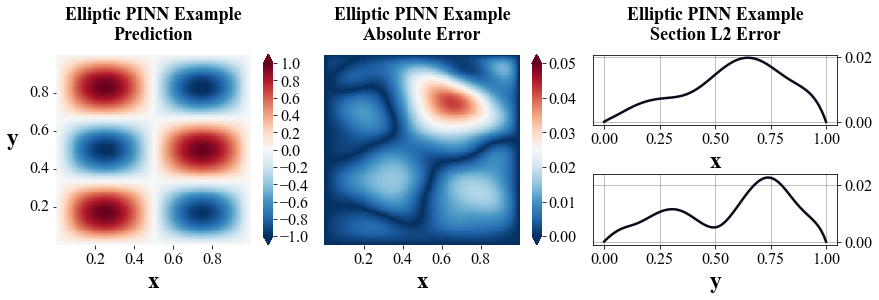

In [708]:
## Result Visualization
import seaborn as sns
from matplotlib.ticker import MaxNLocator

title_fontsize = 18 ; tick_size = 16
cbar_tick_size = 16 ; leg_size = 17  
cmap = 'RdBu_r'

data_lst = [U_hat, U_AbsError, X_Slice_L2Error, Y_Slice_L2Error]

fig = plt.subplots(figsize=(14,3.5))
axes = [plt.subplot(131), plt.subplot(132), plt.subplot(233), plt.subplot(236)]

colorbar_nbins = [10, 5]
colorbar_vmax  = [ 1, 0.05]
colorbar_vmin  = [-1, 0.00]

for i in range(4) :
    if i == 0 or i == 1 :
        hp = sns.heatmap( np.flipud(data_lst[i]), ax=axes[i], 
                          vmax=colorbar_vmax[i], vmin=colorbar_vmin[i], cmap=cmap, # 'magma'
                          cbar_kws={'orientation': 'vertical', 'extend': 'both'})
        
        colorbar = hp.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=cbar_tick_size)
        colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[i]))
        
        axes[i].set_xticks(np.append(np.arange(0, 100, 20),99.5)[1:-1])
        axes[i].set_xticklabels(np.append(np.round(x,1)[::20],1.0)[1:-1])
        axes[i].set_xlabel('x', fontsize=title_fontsize+5, fontweight='bold') 
        
        if i == 0 :
            axes[i].set_yticks(np.append(np.arange(0, 100, 20),100)[1:-1])
            axes[i].set_yticklabels(np.append(np.round(x,1)[::20],1.0)[::-1][1:-1])
            axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)
            axes[i].set_ylabel('y', fontsize=title_fontsize+5, fontweight='bold', rotation=0, labelpad=16)
            axes[i].set_title('Elliptic PINN Example\nPrediction', fontsize=title_fontsize, fontweight='bold', pad=15) 
            
        else :
            axes[i].set_yticks([])    
            axes[i].set_title('Elliptic PINN Example\nAbsolute Error', fontsize=title_fontsize, fontweight='bold', pad=15) 
            
    else :
        if i == 2 :
            axes[i].plot(x, data_lst[i], label='Validate  Physics  Loss', linewidth=2.5, color='#0d0c1d')
            axes[i].set_xlabel('x', fontsize=title_fontsize+5, fontweight='bold') 
            axes[i].set_title('Elliptic PINN Example\nSection L2 Error', fontsize=title_fontsize, fontweight='bold', pad=15) 
        else :
            axes[i].plot(y, data_lst[i], label='Validate  Physics  Loss', linewidth=2.5, color='#0d0c1d')  
            axes[i].set_xlabel('y', fontsize=title_fontsize+5, fontweight='bold')  
        axes[i].grid()
        axes[i].yaxis.tick_right()

    axes[i].tick_params(axis='y', labelsize=tick_size)
    axes[i].tick_params(axis='x', labelsize=tick_size)

plt.subplots_adjust(wspace=0.1, hspace=0.7)
plt.show()

## Wave

In [630]:
# Load Model
Wave_Solver = LoadModel('./data/PDE_Wave_Solver.pkl')
XYT_tensor = Wave_Solver.generate_grid(n_each_axis=100)
sol_pred = Wave_Solver(XYT_tensor).reshape(100,100,100).detach().numpy()
sol_true = Wave_Solver.true_sol(XYT_tensor, k=20).reshape(100,100,100).detach().numpy()

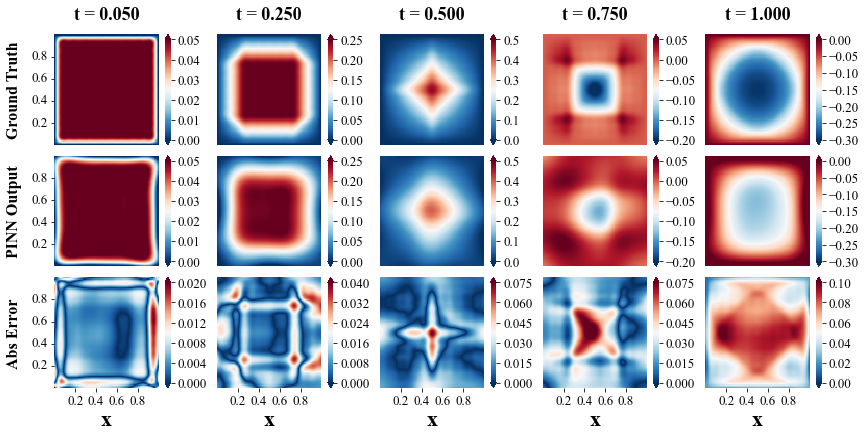

In [697]:
title_fontsize = 18 ; tick_size = 13
cbar_tick_size = 13 ; leg_size = 13
label_fontsize = 16 ; cmap = 'RdBu_r'

fig, axes = plt.subplots( 3, 5 , figsize=( 14, 6.5 ) )
select = [1,5,10,15,20]

# colorbar_nbins = [10, 5.00]
colorbar_nbins = [6, 6, 6, 6, 6]
err_colorbar_nbins = [6, 6, 6, 6, 6]
colorbar_vmax  = [0.05, 0.25, 0.50, 0.05, 0.00]
colorbar_vmin  = [0.00, 0.00, 0.00, -0.2, -0.3]
err_colorbar_vmax  = [0.02, 0.04, 0.075, 0.075, 0.1]

for j in range(5):

    u_true = sol_true[select[j]]
    u_pred = sol_pred[select[j]]
    abs_er = np.abs(u_true-u_pred)
    
    axes[0,j].set_title('t = %.3f'%(select[j]/20), fontsize=title_fontsize, fontweight='bold', pad=15) 

    hp1 = sns.heatmap(np.flipud(u_true), ax=axes[0,j], cmap=cmap, vmax=colorbar_vmax[j], vmin=colorbar_vmin[j],
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    hp2 = sns.heatmap(np.flipud(u_pred), ax=axes[1,j], cmap=cmap, vmax=colorbar_vmax[j], vmin=colorbar_vmin[j],
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    hp3 = sns.heatmap(np.flipud(abs_er), ax=axes[2,j], cmap=cmap, vmax=err_colorbar_vmax[j], vmin=0, 
                            cbar_kws={'orientation': 'vertical', 'extend': 'both'})
    
    colorbar = hp1.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[j]))
    
    colorbar = hp2.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=colorbar_nbins[j]))
    
    colorbar = hp3.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=cbar_tick_size)
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=err_colorbar_nbins[j]))
    
    for i in range(3):
        if i == 2:
            axes[i,j].set_xticks(np.append(np.arange(0, 100, 20),99.5)[1:-1])
            axes[i,j].set_xticklabels(np.append(np.round(x,1)[::20],1.0)[1:-1])
            axes[i,j].set_xlabel('x', fontsize=22, fontweight='bold') 
        else:
            axes[i,j].set_xticks([])    
            
        if j == 0 :
            axes[i,j].set_yticks(np.append(np.arange(0, 100, 20),100)[1:-1])
            axes[i,j].set_yticklabels(np.append(np.round(x,1)[::20],1.0)[::-1][1:-1])
            axes[i,j].set_yticklabels(axes[i,j].get_yticklabels(), rotation=0)
            
            axes[0,j].set_ylabel('Ground Truth', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            axes[1,j].set_ylabel('PINN Output', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            axes[2,j].set_ylabel('Abs Error', fontsize=label_fontsize, fontweight='bold', labelpad=9)
            
        else:
            axes[i,j].set_yticks([])    
            
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        axes[i,j].tick_params(axis='x', labelsize=tick_size)

plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.show()
    